In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from pyearth import Earth
from sklearn.impute import KNNImputer
import xgboost as xgb
import itertools as it
import time as time 
import warnings
warnings.filterwarnings('ignore')

In [229]:
data = pd.read_csv('binned_jobs.csv')

data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,job_title_binned
0,2023,MI,FT,AWS Data Architect,258000,USD,258000,US,100,US,L,data_engineering_and_architecture
1,2023,SE,FT,Data Scientist,225000,USD,225000,US,0,US,M,data_science_and_ml
2,2023,SE,FT,Data Scientist,156400,USD,156400,US,0,US,M,data_science_and_ml
3,2023,SE,FT,Data Engineer,190000,USD,190000,US,100,US,M,data_engineering_and_architecture
4,2023,SE,FT,Data Engineer,150000,USD,150000,US,100,US,M,data_engineering_and_architecture


In [230]:
y1 = data['salary_in_usd']

X1 = data.drop(columns=['salary_in_usd', 'job_title', 'salary'], axis=1)
X1 = pd.get_dummies(X1, drop_first=True)

In [231]:
sc = StandardScaler()
sc.fit(X1)

X_scaled = sc.transform(X1)
X1 = pd.DataFrame(X_scaled)

In [232]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=45)

In [221]:
threshold = 180000

>5 54907.514 (4093.902)
>10 49341.597 (3894.841)
>50 49452.938 (3635.064)
>100 49829.311 (3631.077)
>500 51697.372 (3396.414)
>1000 52007.477 (3383.722)
>2000 52140.610 (3389.215)
>5000 52170.886 (3381.778)


Text(0.5, 0, 'Number of trees')

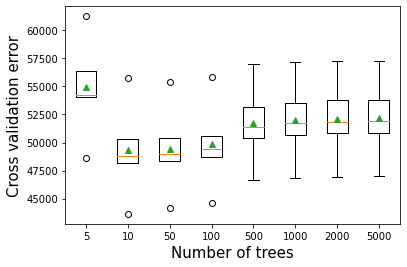

In [206]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [5, 10, 50, 100, 500, 1000, 2000, 5000]
    for n in n_trees:
        models[str(n)] = xgb.XGBRegressor(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 49136.640 (4385.503)
>2 48487.133 (4099.710)
>3 48434.149 (4022.796)
>4 48648.466 (4151.153)
>5 48842.253 (3843.702)
>6 49334.933 (3720.550)
>7 49612.866 (3616.227)
>8 49824.091 (3491.943)
>9 50384.147 (3475.950)
>10 50377.525 (3304.573)
>11 50798.435 (3368.111)
>12 50968.022 (3351.845)
>13 51165.333 (3167.302)
>14 51207.669 (3226.766)
>15 51228.143 (3309.356)
>16 51267.224 (3119.676)
>17 51245.023 (3356.267)
>18 51128.106 (3180.924)
>19 51178.096 (3185.317)
>20 51129.098 (3243.927)


Text(0.5, 0, 'Depth of each tree')

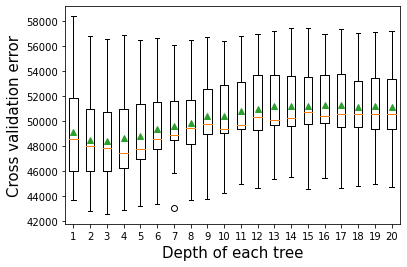

In [207]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define ensemble model
        models[str(i)] = xgb.XGBRegressor(random_state=1,max_depth=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

>0.0100 72273.4 (4464.4)
>0.0500 48637.0 (3798.8)
>0.1000 48697.0 (3726.1)
>0.2000 48958.0 (3616.4)
>0.3000 49334.9 (3720.6)
>0.4000 49483.4 (3668.9)
>0.5000 50007.6 (3759.1)
>0.6000 50584.3 (3634.1)
>0.8000 51059.1 (4096.9)
>1.0000 51595.5 (3763.1)


Text(0.5, 0, 'Learning rate')

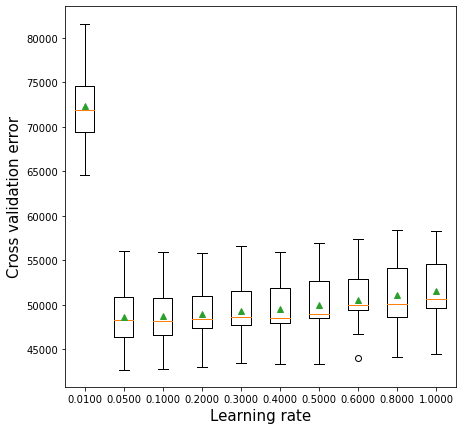

In [208]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(learning_rate=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

>0.0000 49900.7 (3742.4)
>0.5000 49326.5 (3850.1)
>1.0000 49334.9 (3720.6)
>1.5000 49054.0 (3659.7)
>2.0000 49016.6 (3800.3)
>10.0000 48708.5 (3952.9)
>100.0000 48736.0 (3869.6)


Text(0.5, 0, 'reg_lambda')

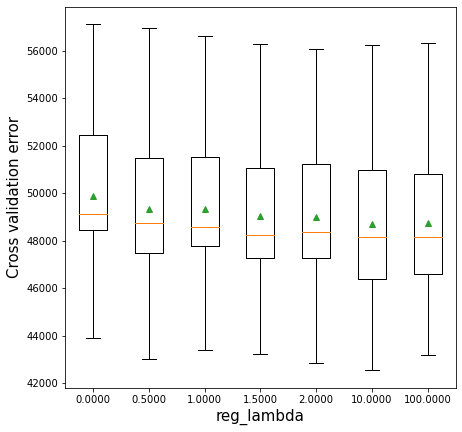

In [209]:
def get_models():
    models = dict()
    # explore 'reg_lambda' from 0.1 to 2 in 0.1 increments
    for i in [0,0.5,1.0,1.5,2,10,100]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(reg_lambda=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('reg_lambda',fontsize=15)

>0.0000 49334.9 (3720.6)
>10.0000 49334.9 (3720.6)
>100.0000 49334.9 (3720.6)
>1000.0000 49334.9 (3720.6)
>10000.0000 49332.3 (3724.5)
>100000.0000 49314.7 (3689.6)
>1000000.0000 49286.4 (3746.7)
>10000000.0000 49283.2 (3716.7)
>100000000.0000 49209.1 (3599.2)
>1000000000.0000 48689.8 (3732.1)


Text(0.5, 0, 'gamma')

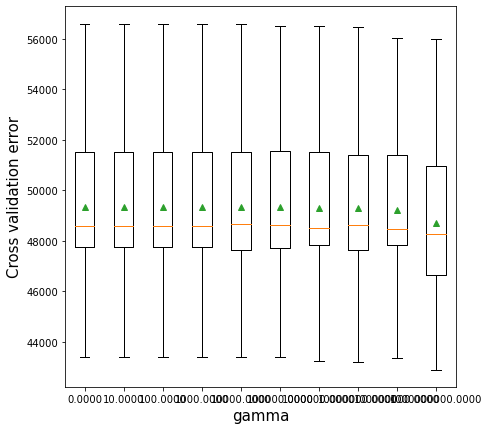

In [210]:
def get_models():
    models = dict()
    # explore gamma from 0.1 to 2 in 0.1 increments
    for i in [0,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9]:
        key = '%.4f' % i
        models[key] = xgb.XGBRegressor(gamma=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('gamma',fontsize=15)

In [31]:
model = xgb.XGBRegressor(max_depth=6,n_estimators=1000,learning_rate=0.05, reg_lambda= 100,
                         random_state=1,subsample=0.75,gamma=1e9,loss='huber').fit(X_train,y_train)

[14:39:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "loss" } are not used.



In [32]:
y_pred = model.predict(X_test)


(y_pred - y_test).abs().mean()

35818.10832168229

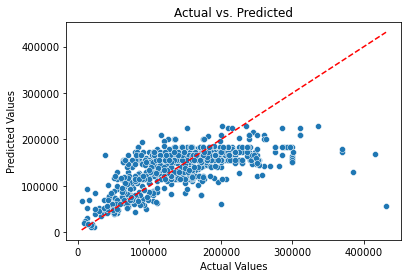

In [235]:
sns.scatterplot(x=y_test, y=y_pred)

min_val = min(min(y_pred), min(y_test))
max_val = max(max(y_pred), max(y_test))
perfect_values = np.linspace(min_val, max_val, 100)
plt.plot(perfect_values, perfect_values, color='red', linestyle='--', label='Perfect Values')

plt.title('Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.show()

In [57]:
means = optimal_params.cv_results_['mean_test_score']
stds = optimal_params.cv_results_['std_test_score']
params = optimal_params.cv_results_['params']
ranks = optimal_params.cv_results_['rank_test_score']

# Combine MAE, rank, and params into a list of tuples
results = list(zip(means, ranks, params))
# Sort the results based on MAE in ascending order
results.sort(key=lambda x: -x[0])  # Sort in descending order of MAE

# Print MAE and rank for each model in ascending order of MAE
for i, (mean, rank, param) in enumerate(results):
    neg_mse = mean  # Negative mean squared error
    mae = -neg_mse  # Convert back to positive MAE
    print("Rank: %d, MAE: %f (params: %r)" % (i+1, mae, param))

Rank: 1, MAE: 1147.717801 (params: {'subsample': 0.75, 'reg_lambda': 1, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 100})
Rank: 2, MAE: 1163.024403 (params: {'subsample': 1.0, 'reg_lambda': 1, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0})
Rank: 3, MAE: 1163.311357 (params: {'subsample': 1.0, 'reg_lambda': 0, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 10})
Rank: 4, MAE: 1163.311474 (params: {'subsample': 1.0, 'reg_lambda': 0, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 100})
Rank: 5, MAE: 1253.229652 (params: {'subsample': 0.75, 'reg_lambda': 0, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0})
Rank: 6, MAE: 1283.526776 (params: {'subsample': 0.75, 'reg_lambda': 0, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0})
Rank: 7, MAE: 1283.838544 (params: {'subsample': 1.0, 'reg_lambda': 0, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate':

In [11]:
start_time = time.time()
param_grid = {'max_depth': [4,6,8,12,15],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 1, 10, 100],
                'n_estimators':[1000, 2000, 3000, 4000],
                'gamma': [0, 10, 100, 10000, 1e6, 1e9] ,
                'subsample': [0.5, 0.75, 1.0]
                }

cv = KFold(n_splits=2,shuffle=True,random_state=45)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=45),                                                       
                             param_distributions = param_grid, n_iter = 500,
                             verbose = 1,
                             n_jobs=-1,
                             scoring='neg_mean_absolute_error',
                             cv = cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 2 folds for each of 500 candidates, totalling 1000 fits
Optimal parameter values = {'subsample': 0.5, 'reg_lambda': 100, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 10}
Optimal cross validation R-squared =  -36568.345355902624
Time taken =  142  minutes


In [21]:
start_time = time.time()
param_grid = {'max_depth': [7,8,9],
              'learning_rate': [0.01, 0.025, 0.05, 0.1],
               'reg_lambda':[0, 1, 10, 100],
                'n_estimators':[1000, 1500, 2000, 2500],
                'gamma': [0, 10, 100, 10000, 1e6, 1e9] ,
                'subsample': [0.5, 0.625, 0.75, 0.875, 1.0]
                }

cv = KFold(n_splits=2,shuffle=True,random_state=45)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=45),                                                       
                             param_distributions = param_grid, n_iter = 200,
                             verbose = 1,
                             n_jobs=-1,
                             scoring='neg_mean_absolute_error',
                             cv = cv)
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 2 folds for each of 200 candidates, totalling 400 fits
Optimal parameter values = {'subsample': 0.625, 'reg_lambda': 100, 'n_estimators': 1500, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 10}
Optimal cross validation R-squared =  -36488.927135106496
Time taken =  37  minutes


In [154]:
lmodel = xgb.XGBRegressor(max_depth=7,n_estimators=3000,learning_rate=0.01, reg_lambda= 100,
                         random_state=1,subsample=0.625,gamma=10,loss='huber').fit(X_trainl,y_trainl)

[15:29:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "loss" } are not used.



In [244]:
model = xgb.XGBRegressor(max_depth=7,n_estimators=2600,learning_rate=0.016, reg_lambda= 100,
                         random_state=1,subsample=0.68,gamma=10,loss='huber').fit(X_train,y_train)

[16:18:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "loss" } are not used.



In [245]:
y_pred = model.predict(X_test)


(y_pred - y_test).abs().mean()

35643.055371211834

In [158]:
pd.DataFrame(y_pred).to_csv('XGBoostpredict.csv')

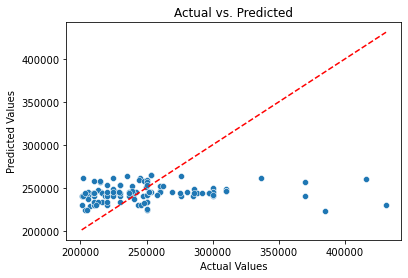

In [84]:
sns.scatterplot(x=y_testl, y=y_pred)

min_val = min(min(y_pred), min(y_testl))
max_val = max(max(y_pred), max(y_testl))
perfect_values = np.linspace(min_val, max_val, 100)
plt.plot(perfect_values, perfect_values, color='red', linestyle='--', label='Perfect Values')

plt.title('Actual vs. Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.show()

In [133]:
new_y_predl = lmodel.predict(X_test)

for i in range(len(y_pred)):
    if y_pred[i] > threshold:
        y_pred[i] = new_y_predl[i]

In [153]:
(y_pred - y_test).abs().mean()

54271.8025241838

In [74]:
y_train[y_train > 200000] = y_train[y_train > 200000] - 30000

In [ ]:
data['abs_diff'] = abs(y_test - y_pred)

data[data['abs_diff'] > 100]